In [194]:
%matplotlib notebook
from quantum_builder import QuantumBuilder
import logging
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets
plt.style.use("support-files/qubit.mplstyle")

MY_COLOURS = {
    "DarkBlue": "#104e8b",     # dark blue (DodgerBlue4)
    "DarkRed": "#ed2200",     # dark red (red2)
    "Green": "#9acd32",     
    "Orange": "#ffc125",      # orange,
    "LightBlue": "#68838b",  # light steel blue,
    "Purple": "#6959cd",  # dark purple
    "Pink": "#ffa07a"  # pink salmon
}
GHz = 10**9
fF = 10**(-15)
e = 1.6*10**(-19)
h = 6.64*10**(-34)

# Resonators
Qubits will interact with different modes of the resonator.

The strength of the coupling will depend on this position:
\begin{equation}
 g = \frac{\pi{E_s}C_{q-r}}{2e}\sqrt{\frac{\hbar\omega_r}{C_r}}\cos(n\pi{\frac{x}{L}})
\end{equation}

- Cosine comes from the positon of the resonator
- $\sqrt{\frac{\hbar\omega_r}{C_r}}$ is the voltage in the resonator
- $C_{q-r}$ is the coupling capacitance between resonator and qubit
- $\frac{\pi{E_s}}{2e}$ is the voltage on the CQPS qubit associated with a phase slip event

In [186]:
L = 1140
qubit_positions = [1/2 + 69.5/L]
N = [2, 3, 4, 5]

def resonator_voltage_scaling(x: float, mode: int):
    "x is in units between 0 and 1"
    return np.abs(np.cos(mode * np.pi * x))
    

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
cm = plt.cm.jet(np.linspace(0, 1, len(N)))
x = np.linspace(0, 1, 1001)

# Plot voltage modes
for idx, n in enumerate(N):
    ax.plot(x, resonator_voltage_scaling(x, n), 
            color=cm[idx], label=f"n={n}")

# Plot qubit positions
for q in qubit_positions:
      ax.vlines(q, 0, 1, color="red", linestyles='--', label=f"{1140*q}$\mu{{m}}$")
        
ax.set_xlim([0.4, 0.6])
ax.set_xlabel("Position along resonator")
ax.set_ylabel("Relative amplitude")
ax.legend()

<IPython.core.display.Javascript object>

# Fitting of qubit spectrum
First we evalaute the transition energies of the cqps system
\begin{equation}
\mathcal{H} = E_L(\hat{n} - f)^2 - \frac{E_s}{2}\bigg[\left|n+1\right\rangle{\left\langle{n}\right|} + \left|n\right\rangle{\left\langle{n+1}\right|}\bigg],
\end{equation}

(It is very similar to the transmon Hamiltonian)
\begin{equation}
    \mathcal{H} = E_C{\left(\hat{N}-N_\text{ext}\right)^2}- \frac{E_J}{2}\bigg(\left|n+1\right\rangle{\left\langle n\right|}+\left|n\right\rangle{\left\langle n+1\right|}\bigg)
\end{equation}
    
I will simply use the transmon Hamitlonian to evaluate energies

In [209]:
data = np.loadtxt("./data/2020-07_cqps-single/two-tone/44_two-tone_8G.txt")
PERIOD = 0.1818
OFFSET = 0.1836 + PERIOD/2

field = (data[:, 0] - OFFSET) / PERIOD
response = data[:, 1]

cqps_qubit_constant_manager:68:print_constants
⮑  ⚛ System setup with the following parameters (can choose to override them):

Energies
EL:                                               72.05 (GHz)
ES:                                               10.00 (GHz)

Raw Parameters
number_of_states:                                 13
inductive_loop_squares:                           30.00 (100x100nm²)

Derived Parameters
inductance:                                       45.00 (nH)


cqps_qubit_constant_manager:57:override_parameters
⮑  Overriding to the following values:
EL:       22.2
ES:       1.56


cqps_qubit_simulator:55:simulate
⮑  💻 Running simulation

cqps_qubit_simulator:96:simulate
⮑  💻 Simulation completed



<IPython.core.display.Javascript object>


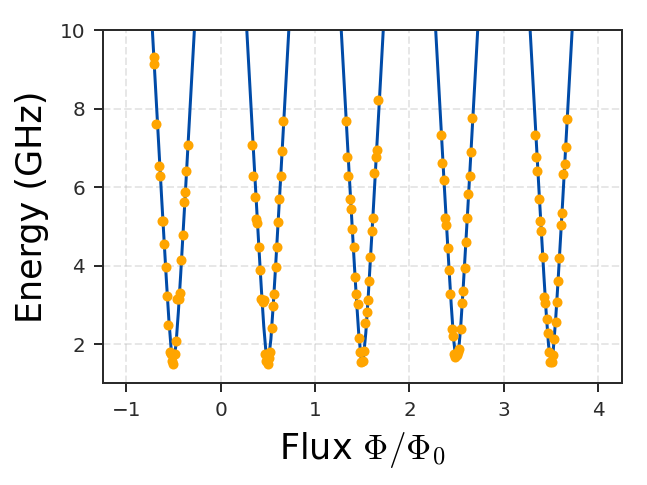

In [221]:
FLUX_NUMBER = np.linspace(-1, 4, 200)
EL = 22.2
ES = 1.56

# Simulation
SIMULATION_PARAMETERS = {
    "number_of_states": 13,
    "number_of_levels_to_simulate": 2
}
QUBIT_PARAMETERS = {
    # We will override them
    "ES": 10,
    "inductive_loop_squares": 30, # 30 140x140nm squares
     **SIMULATION_PARAMETERS
}

cqps_qubit = QuantumBuilder.build_cqps_qubit(
    QUBIT_PARAMETERS, logging_level=logging.INFO,
)
cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)

simulation = cqps_qubit.run_simulation(
    FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
transition01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]

# Plot
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
simulation_graph, = ax.plot(FLUX_NUMBER, transition01)
raw_data_graph, = ax.plot(field, response, 
                          linestyle="", markersize=3,
                          marker="o", color="orange")

ax.set_xlabel("Flux $\Phi/\Phi_0$")
ax.set_ylabel("Energy (GHz)")
ax.set_ylim([1,10])
plt.tight_layout()
# ax[1].plot(FLUX_NUMBER, simulation["eigvals"][:, 1])
# ax[1].plot(FLUX_NUMBER, simulation["eigvals"][:, 0])

In [218]:
def update(ES: float, EL: float):    
    cqps_qubit.cqps_qubit_constant_manager.override_parameters(EL, ES)

    simulation = cqps_qubit.run_simulation(
        FLUX_NUMBER, SIMULATION_PARAMETERS["number_of_levels_to_simulate"])
    transition01 = simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]

    simulation_graph.set_ydata(transition01)
    
    ax.relim()
    ax.autoscale_view()
    plt.tight_layout()
    
ES_widget = ipywidgets.FloatSlider(
    min=0, max=10, step=0.1,
    description="$ES (GHZ)$", value=ES,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=True
)
EL_widget = ipywidgets.FloatSlider(
    min=0, max=30, step=0.1,
    description="$EL (GHz)$", value=EL,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=True
)

ui = ipywidgets.GridspecLayout(3, 1)
ui[0,0] = ES_widget
ui[1,0] = EL_widget

out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "ES": ES_widget,
        "EL": EL_widget,
    }
)  

display(ui, out)

GridspecLayout(children=(FloatSlider(value=1.56, description='$ES (GHZ)$', layout=Layout(grid_area='widget001'…

Output()

# Next we inroduce interaction with the resonator
*Hamitlonian at this stage*

\begin{equation}
 \frac{1}{\hbar}H_{qubit-resonator} = \frac{\omega_{q}}{2}\sigma_z + \omega_r{a^{\dagger}}a + g(a^{\dagger} + a)\sigma_x
\end{equation}

In the truncated matrix form between states $\left|e, N\right\rangle$ and $\left|g, N+1\right\rangle$
\begin{equation}
  \mathcal{H}_{middle} = \begin{pmatrix}
    \frac{\omega_q}{2} + (N)\omega_r & g\sqrt{N+1}\\
    g\sqrt{N+1} & -\frac{\omega_q}{2} + (N+1)\omega_r
  \end{pmatrix}
\end{equation}

We introduce the detuning factor $\delta =\omega_{q} - \omega_{r}$ in order to write out

\begin{equation}
  \mathcal{H}_{middle} = \begin{pmatrix}
    \frac{\delta}{2} + (N+\frac{1}{2})\omega_r & g\sqrt{N+1}\\
    g\sqrt{N+1} & -\frac{\delta}{2} + (N+\frac{1}{2})\omega_r
  \end{pmatrix}
\end{equation}

which reads as
\begin{equation}
  \begin{aligned}
      &= {\hbar\omega_r(N+\frac{1}{2})\mathbb{I} +\frac{ \hbar\delta}{2}\sigma_z} + {\hbar g_0\sqrt{N+1}\sigma_x}\\
      & = {\hbar\omega_r(N+\frac{1}{2})\mathbb{I}} + \frac{1}{2}\sqrt{(\hbar\delta)^2 + 4\hbar^2g_0^2(N+1)} \bigg(\cos(\theta)\sigma_z + \sin(\theta)\sigma_x\bigg)\\
      & = \hbar\omega_r(N+\frac{1}{2})\mathbb{I} + E_{\text{coupled}}(\cos(\theta)\sigma_z + \sin(\theta)\sigma_x)\\
      & \text{where } E_\text{coupled} = \frac{\hbar}{2}\sqrt{\delta^2 + 4g_0^2(N+1)};\qquad \tan(\theta) = \frac{g_0\sqrt{N+1}}{\delta/2}.
  \end{aligned}
\end{equation}

and thus, like in the paper after doing the torating frame

\begin{equation}
E = \left( n + \frac{1}{2} \right)\omega_{r} + \frac{\omega_q}{2} \pm \sqrt{\left( \frac{\delta}{2} \right)^2 + g_0^2(N+1)}
\end{equation}


USE `N = 0`

\begin{equation}
 E = \frac{\omega_{r}}{2} + \frac{\omega_{q}}{2} \pm \sqrt{\left( \frac{\delta}{2} \right)^{2} + g^2}
\end{equation}

and plot $E_{high}(\Phi)$ and $E_{low}(\Phi)$

<IPython.core.display.Javascript object>


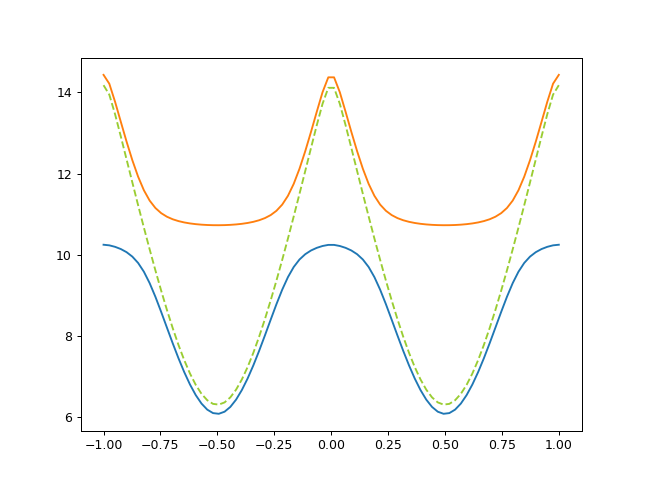

In [137]:
g = 1
omega_r = 10.5

e_high = []
e_low = []

for dE in (simulation["eigvals"][:, 1] - simulation["eigvals"][:, 0]):
    a = dE / 2
    b = omega_r / 2
    c = (dE - omega_r)/2
    
    factor = np.sqrt(c**2 + g**2)
    e_high.append(a+b+factor)
    e_low.append(a+b-factor)
    

# ax.plot(flux_list, np.array(e_high) - np.array(e_low))
fix, ax = plt.subplots(1, 1, figsize=(8,6))

# @interact
# def plotme(scale=(0,50,1), offset=(-10,0,0.1)):
    
ax.plot(FLUX_NUMBER, transition01,
        color=MY_COLOURS["Green"],
        label="Expected",
        linestyle='--'
        )
ax.plot(FLUX_NUMBER, e_low)
ax.plot(FLUX_NUMBER, e_high)
# ax.set_ylim([10, 11])

# Master equations simulation

We are solving the master equation for the full system

 \begin{equation}
  \begin{aligned}
    \dot{\rho} = -\frac{i}{\hbar}\left[ \mathcal{H}, \rho \right] + \mathcal{L}\left[ \rho \right] & = i\frac{\delta_{q}}{2}\left[ \sigma_z\rho - \rho\sigma_z \right] -i\delta_{r}\left[ {a}^{\dagger}a\rho - \rho{a}^{\dagger}a \right]\\
    & - ig{\left[ a\sigma_+\rho - \rho{a}\sigma_+ + {a}^{\dagger}\sigma_{-}\rho - \rho{a}^{\dagger}\sigma_{-} \right]}\\
    & - i{\frac{\Omega}{2}}\left[ a\rho - \rho{a} + {a}^{\dagger}\rho - \rho{a}^{\dagger} \right]\\
    & + \frac{\kappa}{2}\left[ 2a\rho{a}^{\dagger} - {a}^{\dagger}a\rho - \rho{a}^{\dagger}a \right]\\
    & + \frac{\Gamma_{1}}{2}\left[ 2\sigma_{-}\rho\sigma_{+} - \sigma_+\sigma_{-}\rho - \rho\sigma_+\sigma_{-} \right]\\
    & + \frac{\Gamma_{\phi}}{2}\left[ \sigma_z\rho\sigma_z - \rho \right]
  \end{aligned}
 \end{equation}


In [1]:
import qutip as qt

## Representation in 2 qubit - 2 resonator basis (N=0, N=1)

We will use the truncated subspace of vectors in the following $\left|e, n\right\rangle, \left|e, n+1\right\rangle, \left|g, n\right\rangle, \left|g, n+1\right\rangle$ with $n=0$

The representation of operator $\hat{A}$ in this subspace will be
\begin{equation}
 \begin{pmatrix}
   \left\langle e, n\right|\hat{A}{\left|e, n\right\rangle} & \left\langle e, n+1\right|\hat{A}{\left|e, n\right\rangle} & \left\langle e, n\right|\hat{A}{\left|g, n\right\rangle} & \left\langle e, n\right|\hat{A}{\left|g, n+1\right\rangle}\\
   \left\langle e, n+1\right|\hat{A}{\left|e, n\right\rangle} & \left\langle e, n+1+1\right|\hat{A}{\left|e, n\right\rangle} & \left\langle e, n+1\right|\hat{A}{\left|g, n\right\rangle} & \left\langle e, n+1\right|\hat{A}{\left|g, n+1\right\rangle}\\
   \left\langle g, n\right|\hat{A}{\left|e, n\right\rangle} & \left\langle g, n+1\right|\hat{A}{\left|e, n\right\rangle} & \left\langle g, n\right|\hat{A}{\left|g, n\right\rangle} & \left\langle g, n\right|\hat{A}{\left|g, n+1\right\rangle}\\
   \left\langle g, n+1\right|\hat{A}{\left|e, n\right\rangle} & \left\langle g, n+1+1\right|\hat{A}{\left|e, n\right\rangle} & \left\langle g, n+1\right|\hat{A}{\left|g, n\right\rangle} & \left\langle g, n+1\right|\hat{A}{\left|g, n+1\right\rangle}\\
 \end{pmatrix}
\end{equation}

In [60]:
NR = 2
OFFSET = 0

qubit_ket = qt.basis(2,0)
resonator_ket = qt.basis(NR, 0)
example_state = qt.tensor(
    [
        qt.ket2dm(qubit_ket), 
        qt.ket2dm(resonator_ket)
    ])
example_state

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

\begin{equation}
  a^{\dagger}a =
  \begin{pmatrix}
    n & . & . & . \\
    . & n+1 & . & . \\
    . & . & n & . \\
    . & . & . & n+1
  \end{pmatrix}
\end{equation}

In [61]:
op_n = qt.tensor(
    qt.identity(2),
    qt.num(NR, offset=OFFSET)
)
op_n

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 1.]]

\begin{equation}
  a\sigma_{+}=
  \begin{pmatrix}
    . & . & . & \sqrt{n+1} \\
    . & . & . & . \\
    . & . & . & . \\
    . & . & . & .
  \end{pmatrix}
\end{equation}


In [62]:
op_a_sigmaplus = qt.tensor(
    qt.sigmap(),
    qt.destroy(NR, offset=OFFSET)
)
op_a_sigmaplus

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0. 0. 0. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

\begin{equation}
  a^{\dagger}\sigma_-=
  \begin{pmatrix}
    . & . & . & . \\
    . & . & . & . \\
    . & . & . & . \\
    \sqrt{n+1} & . & . & .
  \end{pmatrix}
\end{equation}

In [63]:
op_adagger_sigmaminus = qt.tensor(
    qt.sigmam(),
    qt.create(NR, offset=OFFSET)
)
op_adagger_sigmaminus

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]]

\begin{equation}
  \sigma_z =
  \begin{pmatrix}
    1 & . & . & . \\
    . & 1 & . & . \\
    . & . & -1 & .\\
    . & . & . & -1
  \end{pmatrix}
\end{equation}

In [64]:
op_sigmaz = qt.tensor(
    qt.sigmaz(),
    qt.identity(NR)
)
op_sigmaz

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0. -1.  0.]
 [ 0.  0.  0. -1.]]

\begin{equation}
  a=
  \begin{pmatrix}
    . & \sqrt{n+1} & . & . \\
    . & .& .& .\\
    . & . & . & \sqrt{n+1} \\
    . & . & . & .
  \end{pmatrix}
\end{equation}

In [65]:
op_a = qt.tensor(
    qt.identity(2),
    qt.destroy(NR, offset=OFFSET)
)
op_a

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]]

\begin{equation}
  a^{\dagger}=
  \begin{pmatrix}
    . & . & . & . \\
    \sqrt{n} & .& .& .\\
    . & . & . & . \\
    . & . & \sqrt{n} & .
  \end{pmatrix}
\end{equation}


In [66]:
op_adagger = qt.tensor(
    qt.identity(2),
    qt.create(NR, offset=OFFSET)
)
op_adagger

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]]

\begin{equation}
  \sigma_{-} =
  \begin{pmatrix}
    . & . & . & . \\
    . & . & . & . \\
    1 & . & . & . \\
    . & 1 & . & .
  \end{pmatrix}
\end{equation}

In [67]:
op_sigmaminus = qt.tensor(
    qt.sigmam(),
    qt.identity(NR)
)
op_sigmaminus

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]

\begin{equation}
  \sigma_{+} =
  \begin{pmatrix}
    . & . & 1 & . \\
    . & . & . & 1 \\
    . & . & . & . \\
    . & . & . & .
  \end{pmatrix}
\end{equation}

In [68]:
op_sigmaplus = qt.tensor(
    qt.sigmap(),
    qt.identity(NR)
)
op_sigmaplus

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

## Analytical solution from mathematica
- Using **very** inefficient methods (manual substitution, since Mathematica chockes when told to solve for the 4x4 equations), we have found an analytical solution in the case of weak drive
- $\Omega << 1$ and therefore $\mathcal{O(\Omega^2)}$  terms were set to 0

- The expectation values:

\begin{equation}
 \left\langle a^\dagger \right\rangle = i{\frac{\Omega/2}{\frac{\kappa}{2}-i\delta_r+\frac{g^{2}}{\frac{\Gamma_{1}}{2}+\Gamma_{\phi}-i\delta_r}}}
\end{equation}

\begin{equation}
 \left\langle a \right\rangle = -i{\frac{\Omega/2}{\frac{\kappa}{2}+i\delta_r+\frac{g^{2}}{\frac{\Gamma_{1}}{2}+\Gamma_{\phi}+i\delta_r}}}
\end{equation}

The eventual transmission function
\begin{equation}
 t = \frac{V_{out}}{V_{in}} = -i\frac{1}{2}\frac{C_k^2\omega^2Z}{C_{r}}\left[ \frac{1}{g^2/\delta_q' - \delta_r'}+cc\right]
\end{equation}

Which we can plot as a function of detuning $\delta_r$ and $\delta_q$

In [160]:
# Work in units of MHz. Not sure whether we should be working with radians?

# Estimated - need to improve
Gamma1 = 0.26
GammaPhi = 0
Gamma = Gamma1 + GammaPhi

Es = 2.875*GHz
Ck = 50/10*fF # On design the coupling is 50µm. 1fF per 10µm of interface
Cr = 3/10*fF # 3µm coupling between qubit and resonator
f_probe = 5*GHz #only order of magnitude important
g = ((np.pi * Es * Ck) / (2 * e) * np.sqrt(h * f_probe/Cr))/GHz

# G is coming out too large
#g = 0.1
g = 100

kappa = 1.39 # Taken from paper

"""
See mathematica notebook for how this was evaluated
"""
def transmission(delta_q: float, delta_r: float) -> float:    
    # Auxillary parameters
    qReal = delta_q
    qImag = Gamma
    rReal = delta_r
    rImag = kappa / 2
    
    return (
        (2*g**2*qReal - 2*(qImag**2+qReal**2)*rReal) 
        / 
        (g**4 + 2*g**2*(qImag*rImag - qReal*rReal) + (qImag**2 + qReal**2)*(rImag**2 + rReal**2))
    )

In [140]:
# Example plot
deltaQ = np.linspace(-20, 20, 1001)
deltaR = np.linspace(-20, 20, 1001)

deltaQGrid, deltaRGrid = np.meshgrid(deltaQ, deltaR)

tGrid = transmission(deltaQGrid, deltaRGrid)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.contourf(deltaQGrid, deltaRGrid, tGrid)

<IPython.core.display.Javascript object>

In [169]:
# Let's take the qubit frequency from above
qubit_frequency = transition01
resonator_frequency = 10.5
sweep_frequency = np.linspace(10.4, 10.6, 100)

# Construct a matrix of detunings. We step along the magnetic field (changing the freqyency of the qubit) and 
deltaQ = []
deltaR = []
for fq in qubit_frequency:
    deltaQ.append(sweep_frequency - fq)
    deltaR.append(sweep_frequency - resonator_frequency)
    
deltaQ = np.array(deltaQ)*1000 #to convert to MHz
deltaR = np.array(deltaR)*1000
tGrid = transmission(deltaQ, deltaR)

deltaXGrid, deltaYGrid = np.meshgrid(
    np.linspace(0, len(qubit_frequency), len(qubit_frequency)), 
    sweep_frequency)

fig, ax = plt.subplots(2, 1, figsize=(8, 6))
ax[0].contourf(deltaXGrid, deltaYGrid, np.transpose(tGrid))
ax[0].plot(transition01)
ax[0].set_ylim([10, 11])
ax[1].plot(transition01)
ax[1].axhline(resonator_frequency)
plt.show()

<IPython.core.display.Javascript object>